## Layer

In [23]:
import tensorflow as tf

class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute derivatives for the steady Navier-Stokes equation.

    Attributes:
        model: keras network model.
    """

    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__(**kwargs)

    def call(self, xy):
        """
        Computing derivatives for the steady Navier-Stokes equation.

        Args:
            xy: input variable.

        Returns:
            psi: stream function.
            p_grads: pressure and its gradients.
            u_grads: u and its gradients.
            v_grads: v and its gradients.
        """

        x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
        with tf.GradientTape(persistent=True) as ggg:
            ggg.watch(x)
            ggg.watch(y)
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                gg.watch(y)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    g.watch(y)
                    psi_p = self.model(tf.concat([x, y], axis=-1))
                    psi = psi_p[..., 0, tf.newaxis]
                    p   = psi_p[..., 1, tf.newaxis]
                u   =  g.batch_jacobian(psi, y)[..., 0]
                v   = -g.batch_jacobian(psi, x)[..., 0]
                p_x =  g.batch_jacobian(p,   x)[..., 0]
                p_y =  g.batch_jacobian(p,   y)[..., 0]
                del g
            u_x = gg.batch_jacobian(u, x)[..., 0]
            u_y = gg.batch_jacobian(u, y)[..., 0]
            v_x = gg.batch_jacobian(v, x)[..., 0]
            v_y = gg.batch_jacobian(v, y)[..., 0]
            del gg
        u_xx = ggg.batch_jacobian(u_x, x)[..., 0]
        u_yy = ggg.batch_jacobian(u_y, y)[..., 0]
        v_xx = ggg.batch_jacobian(v_x, x)[..., 0]
        v_yy = ggg.batch_jacobian(v_y, y)[..., 0]
        del ggg

        p_grads = p, p_x, p_y
        u_grads = u, u_x, u_y, u_xx, u_yy
        v_grads = v, v_x, v_y, v_xx, v_yy

        return psi, p_grads, u_grads, v_grads


## Network


In [24]:
class Network:
    """
    Build a physics informed neural network (PINN) model for the steady Navier-Stokes equations.
    """

    def __init__(self):
        """ Setup custom activation functions. """
        self.activations = {
            'tanh': 'tanh',
            'swish': self.swish,
            'mish': self.mish,
        }

    def swish(self, x):
        """ Swish activation function. """
        return x * tf.math.sigmoid(x)

    def mish(self, x):
        """ Mish activation function. """
        return x * tf.math.tanh(tf.softplus(x))

    def build(self, num_inputs=2, layers=[32, 16, 16, 32], activation='swish', num_outputs=2):
        """ Build a PINN model for the steady Navier-Stokes equation with input shape (x,y) and output shape (psi, p). """
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=self.activations[activation], kernel_initializer='he_normal')(x)
        outputs = tf.keras.layers.Dense(num_outputs, kernel_initializer='he_normal')(x)
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

## OPtimizer

In [25]:
class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.
    """

    def __init__(self, model, x_train, y_train, factr=10, pgtol=1e-10, m=50, maxls=50, maxiter=200):
        self.model = model
        self.x_train = [tf.constant(x, dtype=tf.float32) for x in x_train]
        self.y_train = [tf.constant(y, dtype=tf.float32) for y in y_train]
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        self.progbar = tf.keras.callbacks.ProgbarLogger(count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params({'verbose': 1, 'epochs': 1, 'steps': self.maxiter, 'metrics': self.metrics})
        self.loss_values = []

    def set_weights(self, flat_weights):
        shapes = [w.shape for w in self.model.get_weights()]
        split_ids = np.cumsum([np.prod(shape) for shape in [0] + shapes])
        weights = [flat_weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.logcosh(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        self.set_weights(weights)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')
        self.loss_values.append(loss)
        return loss, grads

    def callback(self, weights):
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        initial_weights = np.concatenate([w.flatten() for w in self.model.get_weights()])
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
                                     factr=self.factr, pgtol=self.pgtol, m=self.m,
                                     maxls=self.maxls, maxiter=self.maxiter, callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

## PINN

In [26]:
class PINN:
    """
    Build a physics informed neural network (PINN) model for the steady Navier-Stokes equation.

    Attributes:
        network: keras network model with input (x, y) and output (psi, p).
        rho: density.
        nu: viscosity.
        grads: gradient layer.
    """

    def __init__(self, network, rho=1, nu=0.01):
        """
        Args:
            network: keras network model with input (x, y) and output (psi, p).
            rho: density.
            nu: viscosity.
        """

        self.network = network
        self.rho = rho
        self.nu = nu
        self.grads = GradientLayer(self.network)

    def build(self):
        """
        Build a PINN model for the steady Navier-Stokes equation.

        Returns:
            PINN model for the steady Navier-Stokes equation with
                input: [ (x, y) relative to equation,
                         (x, y) relative to boundary condition ],
                output: [ (u, v) relative to equation (must be zero),
                          (psi, psi) relative to boundary condition (psi is duplicated because outputs require the same dimensions),
                          (u, v) relative to boundary condition ]
        """

        # equation input: (x, y)
        xy_eqn = tf.keras.layers.Input(shape=(2,))
        # boundary condition
        xy_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients relative to equation
        _, p_grads, u_grads, v_grads = self.grads(xy_eqn)
        _, p_x, p_y = p_grads
        u, u_x, u_y, u_xx, u_yy = u_grads
        v, v_x, v_y, v_xx, v_yy = v_grads
        # compute equation loss
        u_eqn = u*u_x + v*u_y + p_x/self.rho - self.nu*(u_xx + u_yy)
        v_eqn = u*v_x + v*v_y + p_y/self.rho - self.nu*(v_xx + v_yy)
        uv_eqn = tf.concat([u_eqn, v_eqn], axis=-1)

        # compute gradients relative to boundary condition
        psi_bnd, _, u_grads_bnd, v_grads_bnd = self.grads(xy_bnd)
        # compute boundary condition loss
        psi_bnd = tf.concat([psi_bnd, psi_bnd], axis=-1)
        uv_bnd = tf.concat([u_grads_bnd[0], v_grads_bnd[0]], axis=-1)

        # build the PINN model for the steady Navier-Stokes equation
        return tf.keras.models.Model(
            inputs=[xy_eqn, xy_bnd], outputs=[uv_eqn, psi_bnd, uv_bnd])

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

## Implementation Part

In [28]:
def uv(network, xy):
    """
    Compute flow velocities (u, v) for the network with output (psi, p).
    Args:
        xy: network input variables as ndarray.
    Returns:
        (u, v) as ndarray.
    """

    xy = tf.constant(xy)
    with tf.GradientTape() as g:
        g.watch(xy)
        psi_p = network(xy)
    psi_p_j = g.batch_jacobian(psi_p, xy)
    u =  psi_p_j[..., 0, 1]
    v = -psi_p_j[..., 0, 0]
    return u.numpy(), v.numpy()

def contour(grid, x, y, z, title, levels=50):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)
    # plot a contour
    plt.subplot(grid)
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    plt.title(title)
    cbar = plt.colorbar(pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)

if __name__ == '__main__':
    """
    Test the physics informed neural network (PINN) model
    for the cavity flow governed by the steady Navier-Stokes equation.
    """

    # number of training samples
    num_train_samples = 1000
    # number of test samples
    num_test_samples = 10

    # inlet flow velocity
    u0 = 1
    # density
    rho = 1
    # viscosity
    nu = 0.01

    # build a core network model
    network = Network().build()
    network.summary()
    # build a PINN model
    pinn = PINN(network, rho=rho, nu=nu).build()




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 32)                96        
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 32)                544       
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,506
Trainable params: 1,506
Non-trainable p

In [29]:

    # create training input
    xy_eqn = np.random.rand(num_train_samples, 2)
    xy_ub = np.random.rand(num_train_samples//2, 2)  # top-bottom boundaries
    xy_ub[..., 1] = np.round(xy_ub[..., 1])          # y-position is 0 or 1
    xy_lr = np.random.rand(num_train_samples//2, 2)  # left-right boundaries
    xy_lr[..., 0] = np.round(xy_lr[..., 0])          # x-position is 0 or 1
    xy_bnd = np.random.permutation(np.concatenate([xy_ub, xy_lr]))
    x_train = [xy_eqn, xy_bnd]

In [30]:
# create training output
zeros = np.zeros((num_train_samples, 2))
uv_bnd = np.zeros((num_train_samples, 2))
uv_bnd[..., 0] = u0 * np.floor(xy_bnd[..., 1])
y_train = [zeros, zeros, uv_bnd]

    # train the model using L-BFGS-B algorithm
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=200)
200/200 [==============================] - 83s 416ms/step


1/1 [==============================] - 0s 134ms/step


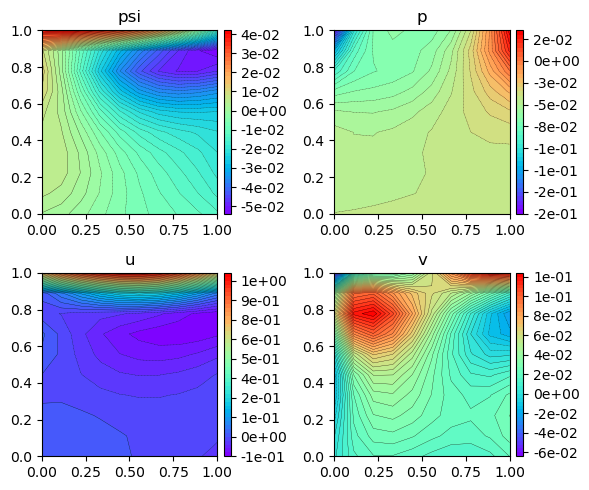

In [13]:
 # create meshgrid coordinates (x, y) for test plots
x = np.linspace(0, 1, num_test_samples)
y = np.linspace(0, 1, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
    # predict (psi, p)
psi_p = network.predict(xy, batch_size=len(xy))
psi, p = [ psi_p[..., i].reshape(x.shape) for i in range(psi_p.shape[-1]) ]
    # compute (u, v)
u, v = uv(network, xy)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
    # plot test results
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 2)
contour(gs[0, 0], x, y, psi, 'psi')
contour(gs[0, 1], x, y, p, 'p')
contour(gs[1, 0], x, y, u, 'u')
contour(gs[1, 1], x, y, v, 'v')
plt.tight_layout()
plt.show()

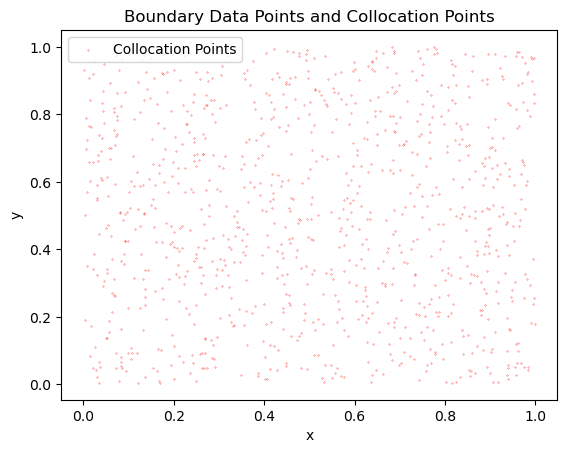

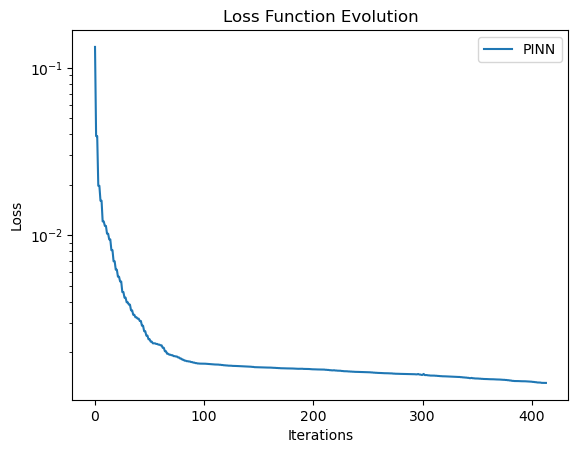

In [33]:
 import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from scipy.stats import qmc

# Plotting boundary data points and collocation points
plt.title("Boundary Data Points and Collocation Points")
plt.scatter(xy_eqn[:, 0], xy_eqn[:, 1], s=0.2, marker=".", c="r", label="Collocation Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Plotting loss function
plt.title("Loss Function Evolution")
plt.semilogy(lbfgs.loss_values, label="PINN")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [3]:
from platform import python_version
print(python_version())

3.7.12


In [16]:
import tensorflow as tf
print(tf.__version__)

2.11.0
